In [1]:
# Ensure notebook is being run from base repository directory
COVID_HOME = "/Users/efua/documents/uni/spring-2021/UROP/covid19-forecast-hub"
import os, sys
try:
    os.chdir(COVID_HOME)
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *

import matplotlib.pyplot as plt

In [61]:
#
# Specify model parameters
#
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    parser.add_argument('--target_dates', '-t', default="std_future")
    args, opt = parser.parse_known_args()
    
    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
else:
    # Otherwise, specify arguments interactively
    gt_id = "cumm_death" #"contest_precip", "contest_tmp2m". choices: "cumm_death", "incd_death", "cumm_case", "incd_case"     
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = 'US'
    quantile = 0.5
    horizon = "1w"

In [62]:
"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth 
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

# Get model list
persistant_models, all_models = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
printf(f"Predictions for models loaded:\n {expert_models}")

Loading cumm_death ground truth
Getting target dates from 2020-01-22 00:00:00 to 2021-03-17 00:00:00.
Loading model predictions for cumm_death, 1w, US, q0.5
Predictions for models loaded:
 ['Auquan-SEIR', 'BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'COVIDhub-trained_ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'FDANIHASU-Sweight', 'GT-DeepCOVID', 'IUPUI-HkPrMobiDyR', 'Imperial-ensemble1', 'Imperial-ensemble2', 'IowaStateLW-STEM', 'JCB-PRM', 'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'MOBS-GLEAM_COVID', 'MSRA-DeepST', 'Microsoft-DeepSTIA', 'NotreDame-mobility', 'OliverWyman-Navigator', 'PSI-DRAFT', 'QJHong-Encounter', 'RPI_UW-Mob_Collision', 'RobertWalraven-ESG', 'SWC-TerminusCM', 'SigSci-TS', 'SteveMcConnell-CovidComplete', 'UA-EpiCovDA', 'UCLA-SuEIR', 'UCM_MESALab-

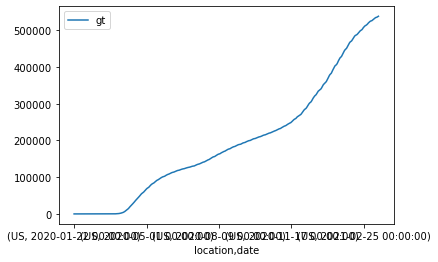

In [4]:
df_gt.plot()

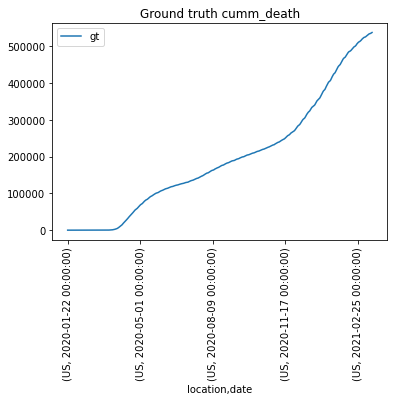

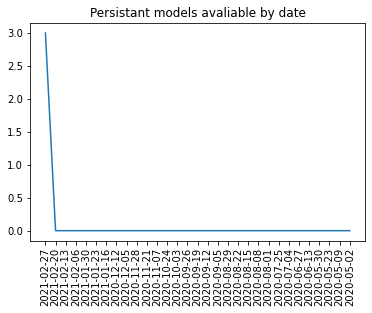

In [5]:
"""
Visualize ground truth 
"""
df_gt.plot()
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()

"""
Visualize avalible models
"""
plt.plot(list(persistant_models.keys()), [len(x) for x in persistant_models.values()])
plt.xticks(rotation=90)
plt.title('Persistant models avaliable by date')
plt.show()

In [6]:
#loading expert models
print("testing: cumulative deaths, 1 wk horizon")
print("")

print("expert models DF:")
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)
model_pred_df.head(100)


testing: cumulative deaths, 1 wk horizon

expert models DF:


,,,value
model,location,target_end_date,
CU-nochange,US,2020-05-02,69433.000000
CU-scenario_mid,US,2020-05-02,69407.000000
GT-DeepCOVID,US,2020-05-09,77808.163100
UT-Mobility,US,2020-05-23,96128.000000
Imperial-ensemble1,US,2020-05-30,104662.000000
Imperial-ensemble2,US,2020-05-30,104671.000000
CU-select,US,2020-06-13,115784.000000
YYG-ParamSearch,US,2020-06-27,123770.842279
SWC-TerminusCM,US,2020-07-04,128581.000000


expert model median plot:


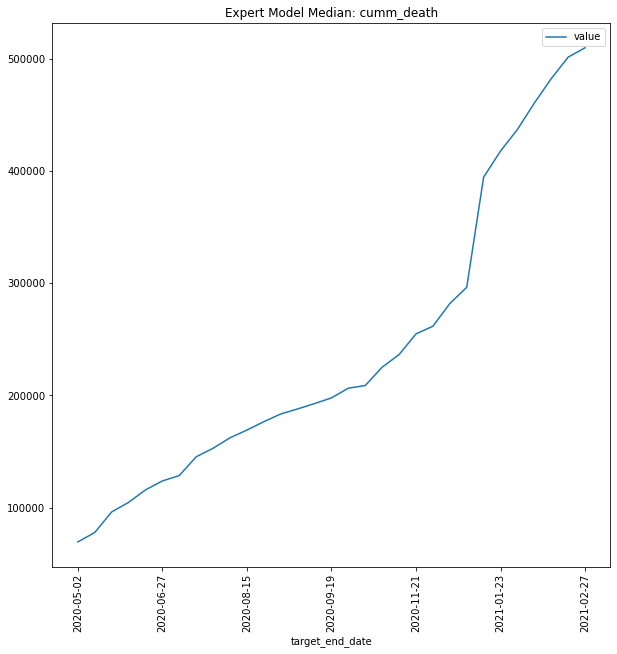


expert model mean plot:


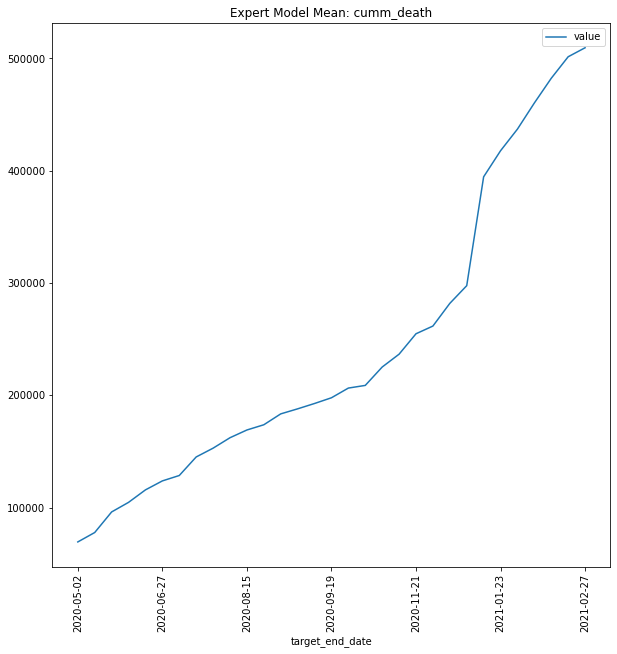


groundtruth plot:


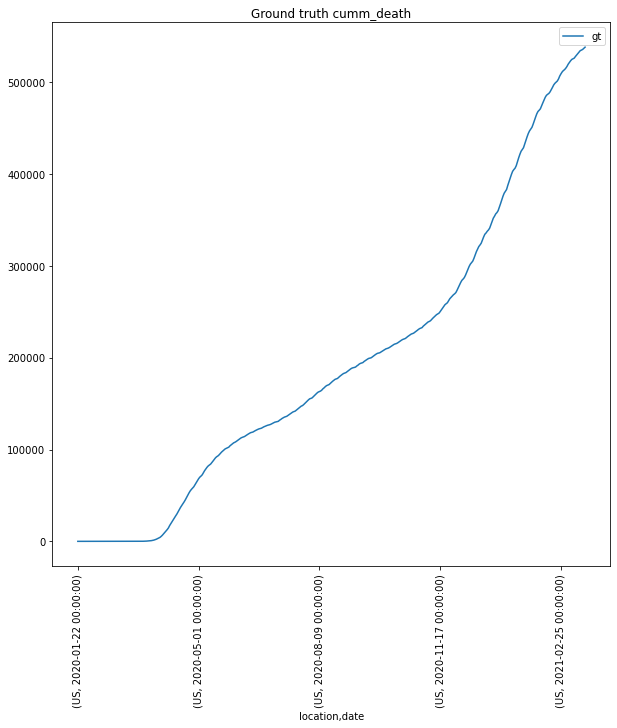

In [7]:
#creating mean and median plots for expert models
print("expert model median plot:")
med_df = model_pred_df.groupby(['target_end_date']).median()
med_df.plot(figsize=(10,10));
plt.xticks(rotation=90)
plt.title(f'Expert Model Median: {gt_id}')
plt.show()



print("")
print("expert model mean plot:")
mea_df = model_pred_df.groupby(['target_end_date']).mean()
mea_df.plot(figsize=(10,10))
plt.xticks(rotation=90)
plt.title(f'Expert Model Mean: {gt_id}')
plt.show()

print("")
print("groundtruth plot:")
df_gt.plot(figsize=(10,10))
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()
print("")


models per date plot:


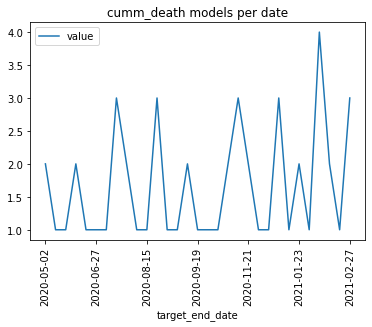

In [8]:
#visualize model count for each date
mod_per_date = model_pred_df.groupby(by='target_end_date').count()
print("")
print("models per date plot:")
mod_per_date.plot()
plt.xticks(rotation=90)
plt.title(f'{gt_id} models per date')
plt.show()
print("")

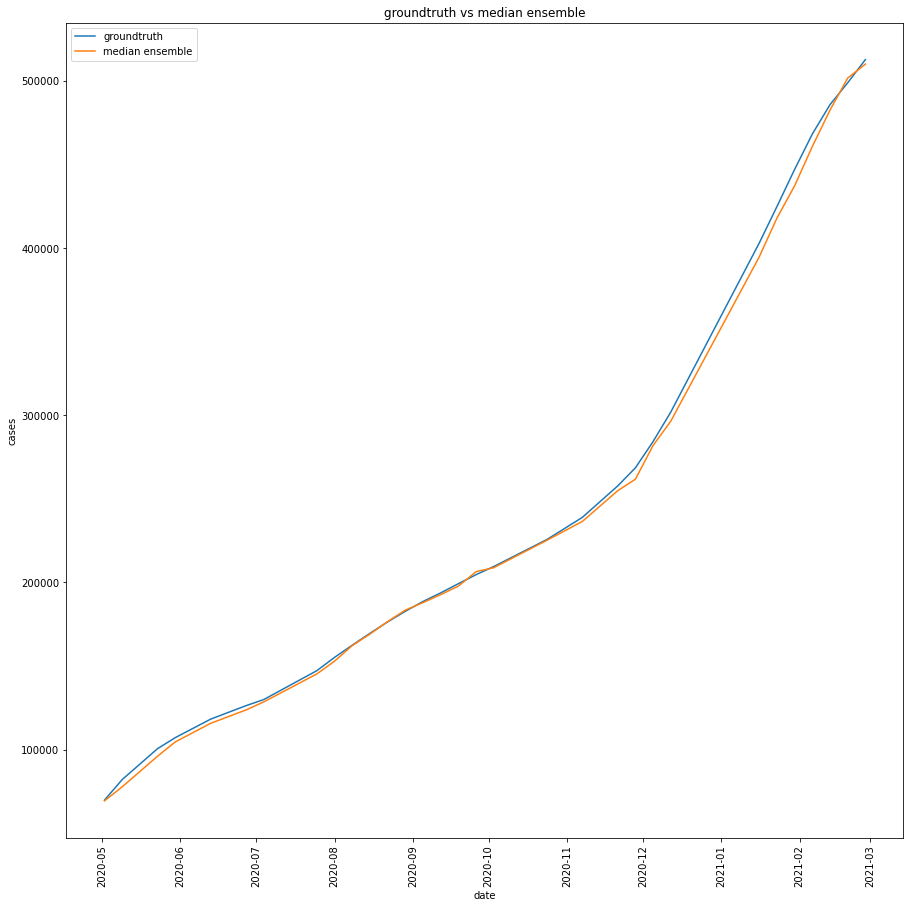

In [58]:
#flatten indexes and extrace dates and cases for axis values
med_model = model_pred_df.groupby(['target_end_date']).median() #load median ensenble again

GT_copy = df_gt #create groundtruth copy and extract axis values
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']


med_model = model_pred_df.groupby(['target_end_date']).median() #create ensemble copy and extract axis values
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_single
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

ensemble_dates = MED_xvals.tolist() #get only groundtruth values that match ensenble dates
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#combined plot of groundtruth, ensemble (median), and individual models.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, MED_yvals, label = "median ensemble")
plt.xticks(rotation=90)
plt.title('groundtruth vs median ensemble')
plt.ylabel('cases')
plt.xlabel('date')
plt.legend()
plt.show()


In [26]:
#make median series
MED_copy = med_df
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    MED_dict[row["target_end_date"]] = row["value"]

med_series = pd.Series(data=MED_dict, index=MED_single['target_end_date'])

#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_single
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MED_single['target_end_date']) #matching gt values to ensemble dates due to missing dates?


___


target_end_date
2020-05-02     69867.0
2020-05-09     82146.0
2020-05-23    100655.0
2020-05-30    107217.0
2020-06-13    118287.0
2020-06-27    126333.0
2020-07-04    129986.0
2020-07-25    147246.0
2020-08-01    155205.0
2020-08-08    162496.0
2020-08-15    169573.0
2020-08-22    176397.0
2020-08-29    182737.0
2020-09-05    188613.0
2020-09-12    193755.0
2020-09-19    199261.0
2020-09-26    204652.0
2020-10-03    209524.0
2020-10-24    225654.0
2020-11-07    238857.0
2020-11-21    257671.0
2020-11-28    268481.0
2020-12-05    284200.0
2020-12-12    301831.0
2021-01-16    402884.0
2021-01-23    424705.0
2021-01-30    446910.0
2021-02-06    468055.0
2021-02-13    485636.0
2021-02-20    498703.0
2021-02-27    512570.0
dtype: float64

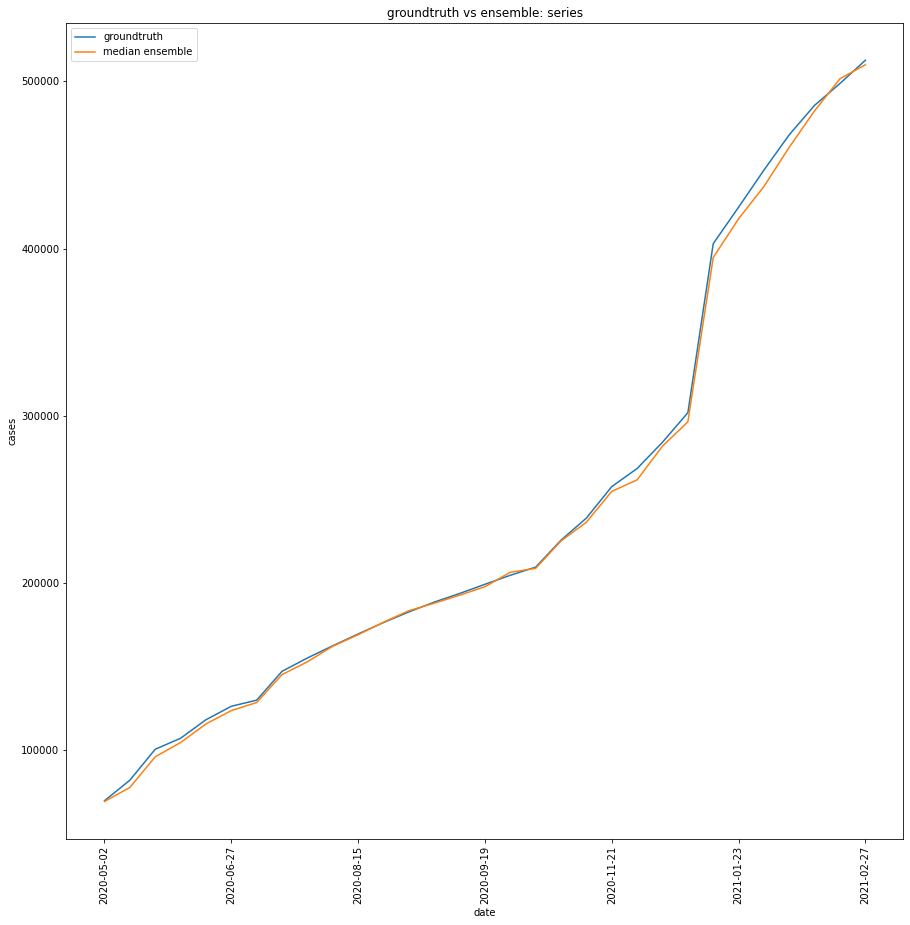

In [57]:
#plot median ensemble series vs groundtruth series
plt.figure(figsize=(15,15))
GT_series.plot(label = "groundtruth")
med_series.plot(label = "median ensemble")
plt.xticks(rotation=90)
plt.title('groundtruth vs ensemble: series')
plt.ylabel('cases')
plt.xlabel('date')
plt.legend()
plt.show()

In [54]:
#loss calculation for ensemble (cumm_deaths)
losses_by_date = MAELoss.loss(0,GT_series,med_series)

#overall average loss
entries = 0
tot = 0
for x in losses_by_date:
    entries += 1
    tot += x
    
error_avg = tot / entries

losses_by_date

target_end_date
2020-05-02     447.000000
2020-05-09    4337.836900
2020-05-23    4527.000000
2020-05-30    2550.500000
2020-06-13    2503.000000
2020-06-27    2562.157721
2020-07-04    1405.000000
2020-07-25    1946.000000
2020-08-01    2275.500000
2020-08-08     265.000000
2020-08-15     451.528560
2020-08-22     197.943117
2020-08-29     727.806523
2020-09-05     659.000000
2020-09-12    1034.376177
2020-09-19    1443.000000
2020-09-26    1800.186548
2020-10-03     702.000000
2020-10-24     465.000000
2020-11-07    2434.976498
2020-11-21    2848.410005
2020-11-28    6791.441948
2020-12-05    2320.000000
2020-12-12    5460.631597
2021-01-16    8291.349478
2021-01-23    6893.962474
2021-01-30    9807.197068
2021-02-06    7448.073800
2021-02-13    3256.790279
2021-02-20    2832.000000
2021-02-27    2693.000000
dtype: float64

In [56]:
print("average ensemble error: " + str(error_avg))

average ensemble error: 2947.666732030965


In [40]:
#ref: median ensemble series
med_series

target_end_date
2020-05-02     69420.000000
2020-05-09     77808.163100
2020-05-23     96128.000000
2020-05-30    104666.500000
2020-06-13    115784.000000
2020-06-27    123770.842279
2020-07-04    128581.000000
2020-07-25    145300.000000
2020-08-01    152929.500000
2020-08-08    162231.000000
2020-08-15    169121.471440
2020-08-22    176594.943117
2020-08-29    183464.806523
2020-09-05    187954.000000
2020-09-12    192720.623823
2020-09-19    197818.000000
2020-09-26    206452.186548
2020-10-03    208822.000000
2020-10-24    225189.000000
2020-11-07    236422.023502
2020-11-21    254822.589995
2020-11-28    261689.558052
2020-12-05    281880.000000
2020-12-12    296370.368403
2021-01-16    394592.650522
2021-01-23    417811.037526
2021-01-30    437102.802932
2021-02-06    460606.926200
2021-02-13    482379.209721
2021-02-20    501535.000000
2021-02-27    509877.000000
dtype: float64

In [41]:
#ref: groundtruth series
GT_series

target_end_date
2020-05-02     69867.0
2020-05-09     82146.0
2020-05-23    100655.0
2020-05-30    107217.0
2020-06-13    118287.0
2020-06-27    126333.0
2020-07-04    129986.0
2020-07-25    147246.0
2020-08-01    155205.0
2020-08-08    162496.0
2020-08-15    169573.0
2020-08-22    176397.0
2020-08-29    182737.0
2020-09-05    188613.0
2020-09-12    193755.0
2020-09-19    199261.0
2020-09-26    204652.0
2020-10-03    209524.0
2020-10-24    225654.0
2020-11-07    238857.0
2020-11-21    257671.0
2020-11-28    268481.0
2020-12-05    284200.0
2020-12-12    301831.0
2021-01-16    402884.0
2021-01-23    424705.0
2021-01-30    446910.0
2021-02-06    468055.0
2021-02-13    485636.0
2021-02-20    498703.0
2021-02-27    512570.0
dtype: float64